In [ ]:
!pip install -qqq soccernet huggingface_hub datasets lsq-ellipse
!huggingface-cli login

In [ ]:
#@title Download data
from SoccerNet.Downloader import SoccerNetDownloader as SNdl
soccerNetDownloader = SNdl(LocalDirectory="SoccerNet")
soccerNetDownloader.downloadDataTask(task="calibration-2023", split=["train","valid","test"])
!unzip SoccerNet/calibration-2023/train.zip
!unzip SoccerNet/calibration-2023/test.zip
!unzip SoccerNet/calibration-2023/valid.zip
!rm SoccerNet/calibration-2023/train.zip
!rm SoccerNet/calibration-2023/test.zip
!rm SoccerNet/calibration-2023/valid.zip
!git clone https://github.com/Spiideo/soccersegcal.git
!git clone https://github.com/NikolasEnt/soccernet-calibration-sportlight.git
%cd soccersegcal
!pip install -r requirements.txt
!pip install vi3o

In [3]:
#@title Constants

LINES_CLASSES = [
    'Big rect. left bottom',
    'Big rect. left main',
    'Big rect. left top',
    'Big rect. right bottom',
    'Big rect. right main',
    'Big rect. right top',
    'Circle central',
    'Circle left',
    'Circle right',
    'Goal left crossbar',
    'Goal left post left ',
    'Goal left post right',
    'Goal right crossbar',
    'Goal right post left',
    'Goal right post right',
    'Middle line',
    'Side line bottom',
    'Side line left',
    'Side line right',
    'Side line top',
    'Small rect. left bottom',
    'Small rect. left main',
    'Small rect. left top',
    'Small rect. right bottom',
    'Small rect. right main',
    'Small rect. right top'
]

CLASS2ID = dict(zip(LINES_CLASSES, list(range(len(LINES_CLASSES)))))
ID2CLASS = dict(zip(list(range(len(LINES_CLASSES))), LINES_CLASSES))

# https://github.com/NikolasEnt/soccernet-calibration-sportlight/blob/8255f5044bc7f2ef4f77e9c1dc67cf0861045290/src/datatools/intersections.py
LINE_INTERSECTIONS = {
    0: ('Goal left crossbar', 'Goal left post left '),
    1: ('Goal left crossbar', 'Goal left post right'),
    2: ('Side line left', 'Goal left post left '),
    3: ('Side line left', 'Goal left post right'),
    4: ('Small rect. left main', 'Small rect. left bottom'),
    5: ('Small rect. left main', 'Small rect. left top'),
    6: ('Side line left', 'Small rect. left bottom'),
    7: ('Side line left', 'Small rect. left top'),
    8: ('Big rect. left main', 'Big rect. left bottom'),
    9: ('Big rect. left main', 'Big rect. left top'),
    10: ('Side line left', 'Big rect. left bottom'),
    11: ('Side line left', 'Big rect. left top'),
    12: ('Side line left', 'Side line bottom'),
    13: ('Side line left', 'Side line top'),
    14: ('Middle line', 'Side line bottom'),
    15: ('Middle line', 'Side line top'),
    16: ('Big rect. right main', 'Big rect. right bottom'),
    17: ('Big rect. right main', 'Big rect. right top'),
    18: ('Side line right', 'Big rect. right bottom'),
    19: ('Side line right', 'Big rect. right top'),
    20: ('Small rect. right main', 'Small rect. right bottom'),
    21: ('Small rect. right main', 'Small rect. right top'),
    22: ('Side line right', 'Small rect. right bottom'),
    23: ('Side line right', 'Small rect. right top'),
    24: ('Goal right crossbar', 'Goal right post left'),
    25: ('Goal right crossbar', 'Goal right post right'),
    26: ('Side line right', 'Goal right post left'),
    27: ('Side line right', 'Goal right post right'),
    28: ('Side line right', 'Side line bottom'),
    29: ('Side line right', 'Side line top'),
}

ELLIPSE_INTERSECTIONS = {
    "Circle left": 'Big rect. left main',
    "Circle right": 'Big rect. right main'
}

FIELD_AREAS = {
        'Goal right': {
            'index': 5,
            'border': [
                'Goal right crossbar',
                'Goal right post right',
                'Side line right',
                'Goal right post left',
            ],
            'contains': [
                'Goal right crossbar',
                'Goal right post right',
                'Goal right post left',
            ],
        },
        'Goal left': {
            'index': 5,
            'border': [
                'Goal left crossbar',
                'Goal left post right',
                'Side line left',
                'Goal left post left ',
            ],
            'contains': [
                'Goal left crossbar',
                'Goal left post right',
                'Goal left post left ',
            ],
        },
        'Small rect. right': {
            'index': 4,
            'border': [
                'Small rect. right top',
                'Small rect. right main',
                'Small rect. right bottom',
                'Side line right',
            ],
            'contains': [
                'Small rect. right bottom',
                'Small rect. right main',
                'Small rect. right top',
            ],
        },
        'Small rect. left': {
            'index': 4,
            'border': [
                'Small rect. left top',
                'Small rect. left main',
                'Small rect. left bottom',
                'Side line left',
            ],
            'contains': [
                'Small rect. left bottom',
                'Small rect. left main',
                'Small rect. left top',
            ],
        },
        'Circle left': {
            'index': 3,
            'border': ['Big rect. left main', 'Circle left'],
            'contains': ['Circle left'],
        },
        'Circle right': {
            'index': 3,
            'border': ['Big rect. right main', 'Circle right'],
            'contains': ['Circle right'],
        },
        'Big rect. right': {
            'index': 2,
            'border': [
                'Big rect. right top',
                'Big rect. right main',
                'Big rect. right bottom',
                'Side line right',
            ],
            'contains': [
                'Big rect. right top',
                'Big rect. right main',
                'Big rect. right bottom',
                'Small rect. right bottom',
                'Small rect. right main',
                'Small rect. right top',
            ],
        },
        'Big rect. left': {
            'index': 2,
            'border': [
                'Big rect. left top',
                'Big rect. left main',
                'Big rect. left bottom',
                'Side line left',
            ],
            'contains': [
                'Big rect. left top',
                'Big rect. left main',
                'Big rect. left bottom',
                'Small rect. left bottom',
                'Small rect. left main',
                'Small rect. left top',
            ],
        },
        'Circle central': {
            'index': 1,
            'border': ['Circle central'],
            'contains': ['Circle central'],
        },
        'Full field': {
            'index': 0,
            'border': [
                'Side line bottom',
                'Side line left',
                'Side line top',
                'Side line right',
            ],
            'contains': [
                'Side line bottom',
                'Side line left',
                'Side line top',
                'Side line right',
                'Big rect. left bottom',
                'Big rect. left main',
                'Big rect. left top',
                'Big rect. right bottom',
                'Big rect. right main',
                'Big rect. right top',
                'Circle central',
                'Circle left',
                'Circle right',
                'Middle line',
                'Small rect. left bottom',
                'Small rect. left main',
                'Small rect. left top',
                'Small rect. right bottom',
                'Small rect. right main',
                'Small rect. right top'
            ],
        }
    }


# https://github.com/Spiideo/soccersegcal/blob/main/soccersegcal/dataloader.py
BAD = {"valid": {11, 32, 60, 64, 71, 82, 85, 108, 129, 151, 176, 200, 280, 284, 295, 310, 315, 367, 374, 381, 407, 411, 420, 458, 459, 465, 521, 525, 527, 532, 536, 538, 544, 553, 572, 579, 592, 595, 614, 617, 638, 651, 710, 756, 780, 786, 790, 799, 801, 809, 813, 847, 873, 876, 883, 884, 914, 920, 927, 962, 965, 993, 1002, 1012, 1015, 1026, 1040, 1046, 1066, 1067, 1078, 1080, 1088, 1096, 1104, 1119, 1139, 1141, 1143, 1148, 1152, 1225, 1244, 1249, 1258, 1264, 1265, 1268, 1284, 1285, 1286, 1300, 1301, 1316, 1318, 1325, 1338, 1341, 1357, 1379, 1394, 1424, 1439, 1444, 1457, 1458, 1467, 1468, 1477, 1493, 1498, 1509, 1545, 1577, 1600, 1619, 1649, 1650, 1737, 1761, 1763, 1768, 1789, 1814, 1816, 1841, 1865, 1870, 1905, 1912, 1920, 1922, 1931, 1945, 1956, 2026, 2056, 2057, 2074, 2096, 2097, 2111, 2112, 2121, 2138, 2143, 2147, 2153, 2155, 2186, 2187, 2194, 2199, 2202, 2232, 2244, 2262, 2282, 2297, 2306, 2317, 2327, 2334, 2358, 2363, 2364, 2375, 2393, 2394, 2397, 2504, 2518, 2521, 2525, 2541, 2554, 2557, 2558, 2562, 2564, 2573, 2580, 2588, 2604, 2613, 2618, 2650, 2671, 2756, 2768, 2800, 2829, 2830, 2832, 2835, 2838, 2871, 2886, 2928, 2941, 2995, 3007, 3015, 3026, 3046, 3049, 3071, 3091, 3106, 3124, 3131, 3132, 3133, 3134, 3149, 3161, 3162, 3179, 3182, 3207},
            "test": {23, 33, 75, 92, 100, 112, 119, 129, 141, 181, 188, 258, 294, 304, 314, 321, 342, 343, 482, 487, 496, 501, 508, 518, 545, 582, 586, 589, 591, 609, 615, 646, 649, 697, 713, 747, 748, 756, 787, 829, 834, 839, 850, 863, 869, 872, 941, 984, 1007, 1020, 1025, 1028, 1030, 1039, 1042, 1071, 1086, 1098, 1115, 1118, 1121, 1125, 1131, 1136, 1158, 1169, 1191, 1223, 1224, 1227, 1245, 1262, 1268, 1269, 1279, 1281, 1307, 1311, 1323, 1326, 1328, 1341, 1357, 1394, 1413, 1414, 1500, 1546, 1584, 1616, 1631, 1640, 1644, 1663, 1698, 1700, 1702, 1707, 1759, 1763, 1788, 1795, 1817, 1886, 1889, 1907, 1930, 1934, 1970, 2051, 2058, 2062, 2070, 2072, 2130, 2173, 2181, 2185, 2188, 2208, 2216, 2268, 2276, 2280, 2286, 2294, 2305, 2307, 2317, 2330, 2346, 2389, 2439, 2453, 2462, 2493, 2517, 2527, 2564, 2570, 2592, 2608, 2621, 2627, 2631, 2637, 2647, 2708, 2713, 2732, 2786, 2850, 2862, 2888, 2899, 2902, 2920, 2925, 2962, 2963, 2972, 2998, 3014, 3029, 3033, 3039, 3040, 3046, 3053, 3056, 3057, 3060, 3064, 3077, 3082, 3086, 3089, 3104, 3122, 3137},
            "train": {81, 87, 89, 109, 128, 153, 154, 186, 195, 198, 227, 274, 280, 284, 288, 296, 300, 336, 339, 340, 350, 351, 372, 395, 400, 402, 409, 419, 426, 431, 432, 433, 435, 451, 544, 609, 644, 658, 711, 723, 724, 794, 840, 877, 901, 903, 972, 983, 1004, 1036, 1081, 1087, 1089, 1110, 1257, 1339, 1342, 1370, 1498, 1516, 1518, 1522, 1532, 1563, 1600, 1643, 1645, 1655, 1666, 1678, 1706, 1712, 1739, 1753, 1844, 1919, 1931, 1937, 1961, 1968, 2029, 2037, 2041, 2052, 2056, 2085, 2115, 2125, 2168, 2236, 2244, 2260, 2261, 2280, 2287, 2307, 2328, 2346, 2367, 2369, 2373, 2380, 2410, 2426, 2443, 2465, 2466, 2511, 2543, 2591, 2629, 2631, 2651, 2656, 2661, 2674, 2692, 2694, 2698, 2707, 2719, 2730, 2740, 2744, 2747, 2751, 2753, 2766, 2776, 2780, 2812, 2821, 2860, 2890, 2930, 2969, 2971, 2973, 2981, 2997, 3019, 3052, 3082, 3168, 3186, 3218, 3247, 3264, 3278, 3366, 3385, 3392, 3434, 3451, 3460, 3486, 3535, 3539, 3556, 3564, 3660, 3662, 3670, 3696, 3743, 3798, 3825, 3841, 3871, 3873, 3894, 3930, 3947, 3948, 3968, 3987, 4005, 4017, 4039, 4053, 4061, 4063, 4102, 4113, 4123, 4144, 4147, 4157, 4178, 4191, 4204, 4216, 4254, 4264, 4273, 4294, 4316, 4337, 4355, 4364, 4386, 4396, 4435, 4485, 4493, 4575, 4599, 4605, 4628, 4672, 4688, 4744, 4758, 4778, 4783, 4784, 4786, 4826, 4861, 4894, 4896, 4902, 4909, 4918, 4923, 4928, 4929, 4932, 4934, 4958, 4959, 4960, 4976, 4977, 4984, 5018, 5035, 5045, 5048, 5053, 5066, 5067, 5070, 5073, 5087, 5089, 5142, 5161, 5169, 5172, 5190, 5194, 5195, 5240, 5241, 5268, 5281, 5293, 5303, 5319, 5360, 5365, 5394, 5395, 5415, 5416, 5446, 5481, 5484, 5528, 5575, 5581, 5626, 5670, 5691, 5721, 5732, 5746, 5762, 5780, 5786, 5796, 5806, 5814, 5927, 5946, 6135, 6150, 6156, 6157, 6164, 6168, 6178, 6203, 6246, 6247, 6250, 6278, 6279, 6315, 6316, 6321, 6323, 6338, 6371, 6388, 6393, 6396, 6404, 6425, 6459, 6462, 6486, 6508, 6518, 6522, 6523, 6553, 6565, 6600, 6614, 6617, 6665, 6674, 6712, 6727, 6756, 6765, 6775, 6781, 6787, 6812, 6855, 6892, 6936, 6940, 6943, 6944, 6955, 6959, 6969, 6981, 6998, 7008, 7025, 7041, 7049, 7061, 7064, 7065, 7092, 7121, 7128, 7146, 7155, 7161, 7164, 7218, 7224, 7241, 7251, 7276, 7290, 7293, 7294, 7299, 7310, 7315, 7334, 7338, 7343, 7344, 7432, 7441, 7442, 7472, 7475, 7529, 7538, 7548, 7554, 7590, 7592, 7623, 7624, 7632, 7644, 7692, 7695, 7702, 7710, 7712, 7719, 7745, 7757, 7781, 7787, 7832, 7845, 7857, 7866, 7867, 7869, 7885, 7896, 7962, 7991, 7996, 8012, 8052, 8085, 8115, 8133, 8137, 8142, 8144, 8158, 8164, 8190, 8214, 8215, 8222, 8250, 8262, 8280, 8312, 8329, 8336, 8338, 8350, 8351, 8378, 8445, 8450, 8455, 8457, 8461, 8474, 8476, 8486, 8499, 8506, 8507, 8516, 8525, 8534, 8556, 8565, 8568, 8571, 8584, 8590, 8595, 8597, 8598, 8638, 8675, 8688, 8700, 8705, 8713, 8732, 8733, 8859, 8881, 8903, 8922, 8924, 8929, 8930, 8952, 8991, 9033, 9040, 9078, 9122, 9158, 9159, 9176, 9198, 9219, 9256, 9261, 9275, 9287, 9371, 9396, 9397, 9423, 9451, 9452, 9455, 9462, 9469, 9482, 9527, 9533, 9538, 9568, 9635, 9640, 9654, 9664, 9667, 9689, 9694, 9718, 9728, 9740, 9750, 9753, 9768, 9771, 9824, 9869, 9876, 9888, 9892, 9894, 9896, 9922, 9923, 9993, 10039, 10067, 10076, 10103, 10104, 10113, 10129, 10157, 10159, 10183, 10193, 10204, 10233, 10237, 10273, 10277, 10282, 10294, 10309, 10311, 10319, 10321, 10336, 10346, 10358, 10363, 10395, 10419, 10455, 10468, 10469, 10471, 10480, 10523, 10534, 10557, 10562, 10593, 10626, 10627, 10686, 10705, 10712, 10724, 10745, 10797, 10799, 10804, 10820, 10821, 10822, 10827, 10860, 10865, 10873, 10874, 10875, 10882, 10916, 10951, 10964, 10973, 10991, 11039, 11054, 11076, 11086, 11098, 11113, 11126, 11137, 11172, 11181, 11219, 11221, 11223, 11237, 11243, 11246, 11247, 11253, 11262, 11304, 11327, 11345, 11346, 11348, 11356, 11366, 11397, 11400, 11411, 11415, 11478, 11513, 11543, 11561, 11569, 11583, 11590, 11597, 11614, 11621, 11640, 11650, 11666, 11677, 11680, 11695, 11700, 11703, 11716, 11731, 11755, 11758, 11764, 11809, 11816, 11817, 11861, 11862, 11878, 11887, 11918, 11946, 11951, 11959, 11975, 11980, 11993, 12008, 12011, 12016, 12044, 12063, 12077, 12093, 12095, 12108, 12113, 12131, 12173, 12177, 12178, 12183, 12184, 12205, 12239, 12248, 12277, 12284, 12285, 12286, 12300, 12318, 12327, 12329, 12333, 12336, 12354, 12357, 12377, 12379, 12380, 12394, 12395, 12399, 12400, 12403, 12406, 12419, 12425, 12431, 12440, 12444, 12482, 12497, 12503, 12507, 12523, 12529, 12540, 12554, 12581, 12611, 12648, 12694, 12727, 12743, 12838, 12850, 12856, 12858, 12870, 12875, 12889, 12890, 12927, 12937, 12949, 12985, 13035, 13050, 13089, 13111, 13128, 13146, 13153, 13168, 13213, 13391, 13398, 13400, 13404, 13408, 13414, 13434, 13492, 13503, 13508, 13541, 13542, 13577, 13578, 13584, 13588, 13649, 13651, 13752, 13756, 13757, 13767, 13771, 13792, 13818, 13847, 13853, 13858, 13879, 13883, 13889, 13896, 13904, 13919, 13928, 13960, 13962, 13973, 13981, 14010, 14021, 14024, 14029, 14076, 14107, 14142, 14182, 14188, 14189, 14201, 14208, 14217, 14229, 14306, 14313, 14317, 14335, 14354, 14357, 14378, 14381, 14414, 14486, 14494, 14509, 14511, 14528, 14529, 14536, 14538, 14550, 14554, 14563, 14575, 14580, 14583, 14601, 14616, 14647, 14657, 14659, 14704, 14756, 14779, 14783, 14812, 14824, 14832, 14842, 14852, 14863, 14869, 14881, 14894, 14901, 14911, 14981, 14997, 15008, 15009, 15023, 15060, 15067, 15070, 15073, 15087, 15090, 15098, 15100, 15107, 15110, 15111, 15117, 15130, 15141, 15154, 15162, 15167, 15170, 15175, 15210, 15212, 15229, 15233, 15241, 15248, 15261, 15262, 15270, 15297, 15315, 15318, 15324, 15339, 15342, 15364, 15368, 15377, 15383, 15392, 15400, 15402, 15403, 15427, 15437, 15471, 15472, 15496, 15498, 15516, 15517, 15521, 15529, 15542, 15545, 15550, 15560, 15564, 15571, 15572, 15578, 15630, 15635, 15660, 15693, 15709, 15718, 15740, 15743, 15755, 15812, 15822, 15831, 15853, 15858, 15860, 15869, 15877, 15884, 15890, 15893, 15895, 15899, 15904, 15919, 15921, 15938, 15970, 15973, 15986, 15998, 15999, 16040, 16070, 16072, 16076, 16091, 16098, 16115, 16128, 16169, 16172, 16173, 16185, 16189, 16191, 16193, 16197, 16203, 16211, 16232, 16233, 16247, 16250, 16255, 16262, 16267, 16305, 16309, 16315, 16320, 16327, 16342, 16356, 16362, 16373, 16380, 16392}
       }

MASK_CLASS_NAMES = ['FullField', 'CircleCentral', 'BigRect', 'CircleSide', 'SmallRect', 'Goal']


In [4]:
#@title Imports

%load_ext autoreload
%autoreload 2
# %cd soccersegcal
from sncalib.detect_extremities import join_points

%cd ../soccernet-calibration-sportlight
import os
import json
import numpy as np
import cv2
import math
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from ellipse import LsqEllipse
from typing import Tuple, List, Dict
from scipy.optimize import fsolve, root
from scipy.ndimage import convolve
from shapely.geometry import LineString, Point

from src.datatools.geom import point_within_img
from src.datatools.line import find_closest_points
from src.datatools.ellipse import add_conic_points, ellipse_line_intersect
from src.datatools.intersections import intersection

ROOT_PATH = "../"

/content/soccernet-calibration-sportlight


In [21]:
#@title Visualisation Helpers

def show_example(id: str, key = None, verbose = True):
    with open(f"{ROOT_PATH}{id}.json", "r") as f:
        data = json.load(f)
    if verbose:
        print(data.keys())
    img = cv2.imread(f"{ROOT_PATH}{id}.jpg")
    height, width, _ = img.shape

    if key:
        for item in data[key]:
            val = (item['x'] * width, item['y'] * height)
            val = int(val[0]), int(val[1])
            cv2.circle(img, val, 10, (255, 255, 0), 2)
    else:
        for p in data:
            coords = data[p]
            for item in coords:
                val = (item['x'] * width, item['y'] * height)
                val = int(val[0]), int(val[1])
                cv2.circle(img, val, 10, (255, 255, 0), 2)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def overlay_mask(img: Image, mask: Image):
    img = img.convert("RGBA")
    if isinstance(mask, list):
        mask = np.array(mask)
    if isinstance(mask, np.ndarray):
        mask = Image.fromarray(mask.astype(np.uint8))
    mask = mask.convert("RGBA")
    newData = []
    for item in mask.getdata():
        if item[0] == 0 and item[1] == 0 and item[2] == 0:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    mask.putdata(newData)
    img.paste(mask, (0, 0), mask)
    return img

def show_segments(segments):
    class_map = np.argmax(np.flip(segments, axis = 0), axis =0) # flip for the smaller
    rgb_image = np.zeros((class_map.shape[0], class_map.shape[1], 3), dtype=np.float32)
    colors = np.array([
        [0, 0, 0],      # Black
        [255, 0, 0],    # Red
        [0, 255, 0],    # Green
        [0, 0, 255],    # Blue
        [255, 255, 0],  # Yellow
        [255, 0, 255],  # Magenta
        [0, 255, 255]   # Cyan
    ]) / 255.0

    rgb_image = colors[class_map]
    return rgb_image

def show_item(item):
    fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 4))
    axs[0].imshow(item['image'])
    axs[0].set_title("Image")
    axs[0].axis('off')

    axs[1].imshow(overlay_mask(item['image'], item['outlines']))
    axs[1].set_title("Outlines")
    axs[1].axis('off')

    axs[2].imshow(show_segments(item['segments']))
    axs[2].set_title("Segments")
    axs[2].axis('off')
            # PART 3: GET MASK OUTLINES
    kernel = np.array([[0, 1, 0],
                        [1, -4, 1],
                        [0, 1, 0]])
    segments = np.array(item['segments']).astype(np.uint8)
    class_edges = np.zeros(segments.shape[1:], dtype=int)

    for i in range(segments.shape[0]):
        edge = convolve(segments[i], kernel, mode='constant', cval=0)
        edge_detected = edge != 0
        class_edges[edge_detected] = i

    axs[3].imshow(overlay_mask(item['image'], class_edges))
    axs[3].set_title("Segments Outlines")
    axs[3].axis('off')
    if item['is_bad']:
        s = f"Bad ID: {item['id']}"
    else:
        s = f"ID: {item['id']}"
    fig.suptitle(s, fontsize = 8)
    plt.subplots_adjust(hspace = -0.2, wspace = -0.05)
    plt.show()



In [6]:
#@title Math Helpers
def fit_ellipse(points) -> Dict:
    ellipse = cv2.fitEllipse(points)
    (xc, yc), (major_axis, minor_axis), rotation_angle = ellipse
    return {
        "center": (int(xc), int(yc)),
        "axes": (int(major_axis/2) , int(minor_axis/2)),
        "deg_angle": rotation_angle,
        "rad_angle": np.deg2rad(rotation_angle)
    }

def get_angle_on_ellipse(curr_point: Tuple, center: Tuple, axes: Tuple , rad_angle):
    x, y = curr_point
    x0, y0 = center
    a, b = axes
    dx = x - x0
    dy = y - y0

    rotated_dx = np.cos(rad_angle) * dx + np.sin(rad_angle) * dy
    rotated_dy = -np.sin(rad_angle) * dx + np.cos(rad_angle) * dy
    return np.degrees(np.arctan2(a * rotated_dy, b * rotated_dx))

def get_furthest_points(line_points):
    p1 = np.array(line_points[0])
    p2 = np.array(line_points[1])
    max_dist = np.linalg.norm(p2 - p1)
    for i in range(len(line_points)):
        for j in range(i + 1, len(line_points)):
            p_test_1 = np.array(line_points[i])
            p_test_2 = np.array(line_points[j])
            dist = np.linalg.norm(p_test_2 - p_test_1)
            if dist > max_dist:
                p1, p2 = p_test_1, p_test_2
                max_dist = dist
    return p1, p2

def ellipse_line_intersection(center, major, minor, angle_rad, line_points):

    # Define the parametric form of the ellipse
    def ellipse(x, y):
        cos_a = np.cos(angle_rad)
        sin_a = np.sin(angle_rad)
        x0, y0 = center
        term1 = ((x - x0) * cos_a + (y - y0) * sin_a) ** 2 / major ** 2
        term2 = ((x - x0) * sin_a - (y - y0) * cos_a) ** 2 / minor ** 2
        return term1 + term2 - 1

    # Define the line in parametric form, assuming line_points are [point1, point2]
    p1, p2 = get_furthest_points(line_points)
    def line(s):
        return p1 + (p2 - p1) * s

    def find_intersection(t):
        x, y = line(t)
        return ellipse(x, y)

    # Find initial t values that might be close to intersections
    t_values = np.linspace(0, 1, 1000)
    initial_ts = [t for t in t_values if np.abs(find_intersection(t)) < 0.1]

    # Find precise intersection points
    intersections = []
    for t in initial_ts:
        t_solution, = fsolve(find_intersection, t)
        if 0 <= t_solution <= 1:
            intersections.append(line(t_solution))

    # Filter unique solutions considering a tolerance
    unique_intersections = np.unique(np.array(intersections).astype(np.int32), axis=0)

    return unique_intersections

def direction_vector(points):
    i = 1
    points = [np.array(x) for x in points]
    while i < len(points) - 1 and np.linalg.norm(points[0] - points[i]) < 10:
        i += 1
    return points[0] - points[i]

def find_extreme_points(points):
    slope = (points[-1, 1] - points[0, 1]) / (points[-1, 0] - points[0, 0]) if points[-1, 0] != points[0, 0] else float('inf')

    # Find extreme points based on the direction of the line
    if abs(slope) > 1:
        # Line is closer to vertical, use y to find extremes
        min_point = points[points[:, 1].argmin()]
        max_point = points[points[:, 1].argmax()]
    else:
        # Line is closer to horizontal, use x to find extremes
        min_point = points[points[:, 0].argmin()]
        max_point = points[points[:, 0].argmax()]

    return min_point, max_point

In [7]:
#@title Processing Helpers
ELLIPSE_INTERSECTIONS = {
    "Circle left": 'Big rect. left main',
    "Circle right": 'Big rect. right main'
}
def check_orient(annotations): # check mislabelled
    # for pair in [("Circle left",'Big rect. left main'), ("Circle right" 'Big rect. right main')]:
    #     if (pair[0] in annotations) ^ (pair[1] in annotations):
    left = []
    right = []
    for k in annotations:
        if 'goal' not in k.lower():
            if 'left' in k:
                left.append(k)
            if 'right' in k:
                right.append(k)
    left_count = len(left)
    right_count = len(right)

    if abs(left_count-right_count) > 2: # something is probably mislabelled
        if left_count == 1:
            src = left[0]
            dst = src.replace("left", "right")
        elif right_count == 1:
            src = right[0]
            dst = src.replace("right", "left")
        else:
            return annotations
            # continue
        if src in annotations:
            if dst in annotations:
                annotations[dst] += annotations[src]
            else:
                annotations[dst] = annotations[src]
            del annotations[src]
    return annotations

def read_annotations(id: str, img_size: Tuple = (960, 540), derive_intersections:bool = True) -> Tuple[Dict, Dict]:
    w, h = img_size
    with open(f"{ROOT_PATH}{id}.json", "r") as f:
        annotations = json.load(f)

    res = {}
    for cls_id in annotations:
        if len(annotations[cls_id]) <= 1:
            continue
        res[cls_id] = []
        for point in annotations[cls_id]:
            res[cls_id].append((point['x'], point['y']))
    annotations = res
    annotations = check_orient(annotations)
    if derive_intersections:
        inters = {}
        for i, (line1_name, line2_name) in LINE_INTERSECTIONS.items():
            if line1_name in annotations and line2_name in annotations:
                if len(annotations[line1_name]) > 1 and len(annotations[line2_name]) > 1:
                    inters[(line1_name, line2_name)] = intersection(
                                                            np.array(annotations[line1_name]) * img_size,
                                                            np.array(annotations[line2_name]) * img_size)


        inters = {i: point_within_img(inters[i], img_size, margin=0)
           for i in inters}
        for key, value in inters.items():
            a, b = key
            if value:
                normalized = (value[0]/ img_size[0], value[1]/ img_size[1])
                annotations[a].append(normalized)
                annotations[b].append(normalized)

    abs_annotations = {}
    for class_name, raw_points in annotations.items():
        abs_annotations[class_name] = np.array([(x[0] * w, x[1] * h) for x in raw_points]).astype(np.float32)

    return annotations, abs_annotations

def default_drawer(mask: np.array, points: np.array, class_number: int, sort: bool = True, close: bool = False):
    if sort:
        centroid = np.mean(points, axis=0)
        angles = np.arctan2(points[:, 1] - centroid[1], points[:, 0] - centroid[0])
        sort_order = np.argsort(angles)
        points = points[sort_order]
    mask = cv2.polylines(mask, [points.astype(np.int32)], close, class_number + 1, 2)
    return mask


In [8]:
#@title Problematic examples

def swap(fpath: str, src, dst):

    with open(f"../{fpath}" + ".json", "r") as f:
        data = json.load(f)
    if src in data:
        if dst in data:
            data[dst] += data[src]
        else:
            data[dst] = data[src]
        del data[src]
    with open(f"../{fpath}" + ".json", "w") as f:
        json.dump(data, f)

# src is incorrect
to_fix = [
        {
            "fpath": "train/15019",
            "src": 'Circle right',
            "dst": 'Circle central'
        },
        {
            "fpath": "train/08785",
            "src": 'Middle line',
            "dst": 'Circle central'
        },
        {
            "fpath": "train/02426",
            "src": 'Big rect. left main',
            "dst": 'Big rect. right main'
        },
        {
            "fpath": "test/00823",
            "src": 'Line unknown',
            "dst": 'Goal right post right'
        },
        {
            "fpath": "train/07449",
            "src": 'Circle right',
            "dst": 'Circle left'
        },
        {
            "fpath": "train/09740",
            "src": 'Big rect. left main',
            "dst": 'Big rect. right main'
        },
        {
            "fpath": "train/09674",
            "src": 'Circle left',
            "dst": 'Circle right'
        },
        {
            "fpath": "train/09674",
            "src": 'Circle right',
            "dst": 'Circle central'
        },
        {
            "fpath": "train/13537",
            "src": "Line unknown",
            "dst": "Middle line"
        },
        {
            "fpath": "train/03820",
            "src": "Line unknown",
            "dst": "Big rect. right bottom"
        },
        {
            "fpath": "train/14948",
            "src": "Line unknown",
            "dst": "Big rect. right bottom"
        },
        {
            "fpath": "train/04434",
            "src": "Line unknown",
            "dst": "Big rect. left bottom"
        },
        {
            "fpath": "train/16302",
            "src": "Line unknown",
            "dst": "Side line top"
        },
        {
            "fpath": "train/14244",
            "src": "Line unknown",
            "dst": "Big rect. right bottom"
        },
        {
            "fpath": "valid/03102",
            "src": "Line unknown",
            "dst": "Side line right"
        },
        {
            "fpath": "test/01960",
            "src": "Goal unknown",
            "dst": "Goal left crossbar"
        },
        {
            "fpath": "test/03134",
            "src": "Line unknown",
            "dst": "Big rect. right top"
        },
]

for item in to_fix:
    swap(**item)

def del_unknown(fpath, name: str = 'Line unknown'):
    with open(f"../{fpath}" + ".json", "r") as f:
        data = json.load(f)
    if name in data:
        del data[name]
    with open(f"../{fpath}" + ".json", "w") as f:
        json.dump(data, f)


to_del = ['train/12506', 'train/05777', "train/05752", "train/12675", "train/02208", "train/03352",
          "train/07810", "train/13496", "train/01548", "train/02539", "train/06971", "train/00703",
          "train/12715", "train/01199", "train/16302", "train/07907", "train/02556", "valid/00616",
          "valid/00262", "valid/02702", "valid/00249", "test/02461", "test/00292", "test/02405",
          "test/02587", "train/03353", "train/04438"]
for item in to_del:
    del_unknown(item)

In [9]:
#@title SoccerSegCal

class Line:
    def __init__(self, pkts, image_shape):
        self.image_shape = image_shape
        self.missing = False
        pkts = [np.array((p[0] * image_shape[1], p[1] * image_shape[0])) for p in pkts]
        pkts = np.array(join_points(pkts, float('Inf'))[0])
        self.original = LineString(pkts)
        p1 = self.connect_to_image_border(pkts[0], self.direction(pkts))
        p2 = self.connect_to_image_border(pkts[-1], self.direction(pkts[::-1]))
        self.line_string = LineString(np.vstack([[p1], pkts, [p2]]))
        self.padding = [LineString([p1, pkts[0]]), LineString([pkts[-1], p2])]

    def direction(self, pkts):
        i = 1
        while i < len(pkts) - 1 and np.linalg.norm(pkts[0] - pkts[i]) < 10:
            i += 1
        return pkts[0] - pkts[i]


    def connect_to_image_border(self, p, v):
        if p is None:
            return 0, None
        v = v / np.linalg.norm(v)
        tt  = [-p[0] / v[0], -p[1] / v[1], (self.image_shape[1] - 1 - p[0]) / v[0], (self.image_shape[0] - 1 - p[1]) / v[1]]
        tt = [t for t in tt if t >= 0 and np.isfinite(t)]
        if len(tt) == 0:
            return p
        t = min(tt)
        return p + t * v


class MisingLine(Line):
    def __init__(self, image_shape) -> None:
        self.image_shape = image_shape
        self.pkts = [None, None]
        self.v1 = self.v2 = None
        self.missing = True

    def connect(self, other):
        pass

    def match_direction(self, other):
        pass


In [16]:

def process_indiv(id: str) -> Dict:
    img = Image.open(f"{ROOT_PATH}/{id}.jpg")
    width, height = img.size
    tmp = id.split("/")
    s = tmp[0]
    num_id = int(tmp[1])
    annotations, abs_annotations = read_annotations(id, (width, height))
    if len(abs_annotations) == 0:
        return None

    ### PART 1: OUTLINE MASK
    outline_mask = np.zeros((height, width), dtype=np.uint8) # numpy reads (height, width, channels)
    for class_name, abs_points in abs_annotations.items():
        class_number = CLASS2ID[class_name]
        if 'circle' in class_name.lower():
            if len(abs_points) < 5: # unable to fit a regression
                outline_mask = default_drawer(outline_mask, abs_points, class_number, sort=True)
            else:
                reg_res = fit_ellipse(abs_points)
                if 'central' in class_name.lower():
                    outline_mask = cv2.ellipse(outline_mask, reg_res['center'], reg_res['axes'], reg_res['deg_angle'], 0, 360, class_number + 1, 2)
                else: # Half Ellipse
                    other_name = ELLIPSE_INTERSECTIONS[class_name]
                    out = []
                    if other_name in abs_annotations and (len(abs_annotations[other_name]) > 1):
                        out = ellipse_line_intersection(reg_res['center'], reg_res['axes'][0], reg_res['axes'][1], reg_res['rad_angle'], abs_annotations[other_name])
                    if len(out) == 0: # unable to find intersection
                        outline_mask = default_drawer(outline_mask, abs_points, class_number, sort=True)
                    else:
                        if len(out) == 1:
                            out = [out[0], abs_points[-1]]
                        extreme_angles = []
                        for p in out:
                            extreme_angles.append(get_angle_on_ellipse(p, reg_res['center'], reg_res['axes'], reg_res['rad_angle']))
                        outline_mask = cv2.ellipse(outline_mask, reg_res['center'], reg_res['axes'], reg_res['deg_angle'],
                                                    extreme_angles[0], extreme_angles[1], class_number + 1, 2)
        else:
            outline_mask = default_drawer(outline_mask, abs_points, class_number, sort=False)

        # PART 2: GET FULL MASKS
        # https://github.com/Spiideo/soccersegcal/blob/main/soccersegcal/dataloader.py
        segments = np.zeros((6,) + (height, width), np.uint8)
        for name, area in FIELD_AREAS.items():
            all_lines = [Line(annotations[n], (height, width)).original.coords
                         for n in area['contains'] if n in annotations]
            if len(all_lines) == 0:
                continue
            center_x, center_y = map(int, np.round(np.vstack(all_lines).mean(0)))
            center_x = min(max(center_x, 0), width - 1)
            center_y = min(max(center_y, 0), height - 1)

            rim = []
            for n in area['border']:
                if n in annotations:
                    rim.append(Line(annotations[n], (height, width)))
                else:
                    rim.append(MisingLine((height, width)))

            segs = np.zeros((height, width), np.uint8)
            plot_lines = [np.int32(l.line_string.coords) for l in rim if not l.missing]
            cv2.polylines(segs, plot_lines, False, 255, 1)

            if segs[max(center_y-1, 0):min(center_y+2, height), max(center_x-1, 0):min(center_x+2, width)].max() == 255:  # If the center is on the line try moving it towards the long border not contained
                for n in area['border']:
                    if n not in area['contains'] and n in annotations:
                        l = Line(annotations[n], (height, width)).line_string
                        p = np.array(l.interpolate(l.project(Point([center_x, center_y]))).coords)[0]
                        p -= (center_x, center_y)
                        l = np.linalg.norm(p)
                        if l > 0:
                            p /= l
                            center_x, center_y = map(int, (center_x, center_y) + 2 * p)
                            center_x = min(max(center_x, 0), width - 1)
                            center_y = min(max(center_y, 0), height - 1)

            cv2.floodFill(segs, None, (center_x, center_y), 255)
            cv2.polylines(segs, plot_lines, False, 0, 1)

            segments[area['index']][segs>0] = segs[segs>0]

        background = np.logical_not(np.sum(segments, axis=0, keepdims=True).astype(bool))
        segments = np.concatenate((segments, background), axis=0)

    return {
        'image': img,
        'outlines': outline_mask.astype(np.uint8),
        'segments': np.array(segments, dtype=bool),
        'id': num_id,
        'is_bad': num_id in BAD[s]
    }

In [ ]:
def generator(img_paths):
    for p in img_paths:
        id = p.replace(".jpg", "")
        try:
            out = process_indiv(id)
            if out is None:
                pass
            else:
                yield out
        except Exception as e:
            print("ERROR: ", id, e)
            pass


from datasets import Dataset, Features, Array3D, Array2D, Sequence, DatasetDict, Value
import datasets


train_paths = [r'train/' + x for x in os.listdir(ROOT_PATH + 'train') if x.endswith('.jpg')]
train_dataset = Dataset.from_generator(generator, gen_kwargs={"img_paths": train_paths}, writer_batch_size = 500, num_proc = 1)
!rm -rf 'content/train/'

val_paths = [r'valid/' + x for x in os.listdir(ROOT_PATH + 'valid') if x.endswith('.jpg')]
val_dataset = Dataset.from_generator(generator, gen_kwargs={"img_paths": val_paths}, writer_batch_size = 500, num_proc = 1)
!rm -rf 'content/valid/'


test_paths = [r'test/' + x for x in os.listdir(ROOT_PATH + 'test') if x.endswith('.jpg')]
test_dataset = Dataset.from_generator(generator, gen_kwargs={"img_paths": test_paths}, writer_batch_size = 500, num_proc = 1)
!rm -rf 'content/test/'

dataset = DatasetDict({
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
})

dataset.push_to_hub("nreHieW/SoccerNet_Field_Segmentation")


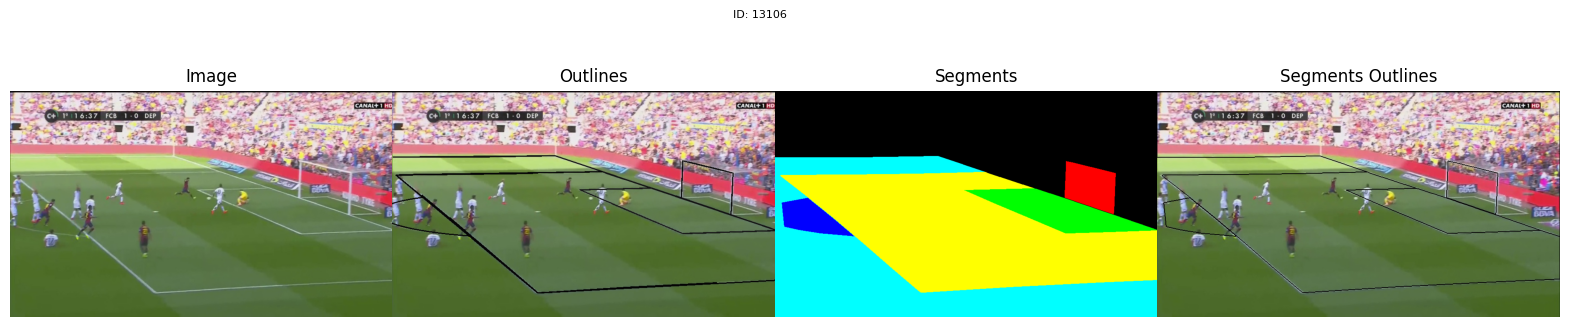

In [22]:
show_item(dataset['train'][99])